# Poisson regression (GAM) COVID-19 Prediction

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

pd.options.display.max_columns = None
pd.options.display.max_colwidth = 500

# Data viz
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

plotly.offline.init_notebook_mode()
sns.set(style="darkgrid", rc={"figure.figsize": (11.7, 8.27)})

# Modeling
from pygam import PoissonGAM, s, l, f

# Other
from datetime import date, timedelta
import os
import random
import sys

# Custom module
module_path = os.path.abspath(os.path.join("../src"))
if module_path not in sys.path:
    sys.path.append(module_path)

from plotting import plot_predictions
from stem_poisson_gam import preprocess_data, StemPoissonRegressor
from utils import get_covid_data, get_all_covid_data

# Reload imported code
%reload_ext autoreload
%autoreload 2

# Print all output
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Set seeds for reproducibility
rand_seed = 2
np.random.seed(rand_seed)
random.seed(rand_seed)

## About

The goal is to provide the most accurate forecasts for COVID-19 in Canada for new cases, deaths and recovered cases.  We'll be using an approach similar to that in the paper [Spatiotemporal Dynamics, Nowcasting and Forecasting of COVID-19 in the United States](https://arxiv.org/abs/2004.14103) which uses a generalized additive model with Poisson distribution using temporal variables (number of infected, susceptible cases at time $t-1$), spatial coordinates, time varying covariates (control measures), and constant covariates (demographic, economic, etc). For now we only use temporal variables $I_{it}$ and $Z_{it}$.

## Load data and EDA

**Given variables**
- $Y_{it}$: Current number of new case at time t for area i. Column "cases" in cases_timeseries_prov.csv
- $I_{it}$: Cumulative number of active infectious cases. Column "active_cases" in active_timeseries_prov.csv
- $C_{it}$: Cumulative confirmed cases up to time t. Column "cumulative_cases" in active_timeseries_prov.csv
- $R_{it}$: Cumulative number of infections. Column "cumulative_recovered" in active_timeseries_prov.csv

**Transformed variables**
- $N_{i}$: Population of region i. Column "population"
- $\Delta D_{it}$: New deaths/recovered cases at time t. Column "removed"
- $S_{it}$: Number of susceptible subjects at time t defined by $S_{it} = N_i - C_{it}$. Column "susceptible"
- $Z_{it}$: Log ratio of susceptible subjects $Z_{it} = log(S_{it} / N_i)$. Column "percent_susceptible" without log transform.

In [27]:
# Read in data
data_path = '../data/timeseries_prov'
cases_provinces = pd.read_csv(data_path + '/cases_timeseries_prov.csv')
active_cases_provinces = pd.read_csv(data_path +  '/active_timeseries_prov.csv')
mortality_provinces = pd.read_csv(data_path + '/mortality_timeseries_prov.csv')
recovered_provinces = pd.read_csv(data_path + '/recovered_timeseries_prov.csv')

# Province population data
prov_map = {
    'British Columbia': 'BC',
    'Newfoundland and Labrador': 'NL', 
    'Northwest Territories': 'NWT',
    'Prince Edward Island': 'PEI'
}

province_populations = (
    pd.read_csv('../data/canada_prov_population.csv')
    .rename(columns = {'GEO': 'province', 'VALUE': 'population'})
    .replace({'province': prov_map})
    .loc[:, ['province', 'population']]
)


# Preprocessing dataframes to be merged
recovered_provinces = recovered_provinces.rename(columns = {'date_recovered': 'date'}).loc[:, ['province', 'date', 'recovered']]
mortality_provinces = mortality_provinces.rename(columns = {'date_death_report': 'date'}).loc[:, ['province', 'date', 'deaths']]

# Preprocessing
format = "%d-%m-%Y"
active_cases_provinces = (
    active_cases_provinces
    .rename(columns = {"date_active": "date"})
    
    # Merge deaths and recovered data
    .merge(mortality_provinces, how='left', on=['province', 'date'])
    .merge(recovered_provinces, how='left', on=['province', 'date'])
    .fillna(0)
    
    # Format date and add new cases data
    .assign(date = lambda x: pd.to_datetime(x["date"], format=format).dt.date,
            cases = cases_provinces['cases'])
    .query('province != "Repatriated"')
    
    # Add population data per province
    .merge(province_populations, how='left', on='province')
    
    # Add transformed variables
    .assign(removed = lambda x: x['recovered'] + x['deaths'],
            susceptible = lambda x: x['population'] - x['cumulative_cases'],
            percent_susceptible = lambda x: x['susceptible'] / x['population'])
)

# Get first and last day of reports
start_date = active_cases_provinces["date"].min()
end_date = active_cases_provinces["date"].max()

# Get list of provinces
provinces = active_cases_provinces["province"].unique()
provinces = ['Ontario', 'Quebec', 'BC', 'Alberta']

# Save dataframe
active_cases_provinces.to_csv('../data/active_cases_provinces.csv')

# Show dataframe
active_cases_provinces.head(10)

province        date  cumulative_cases  cumulative_recovered  \
0  Alberta  2020-01-25                 0                     0   
1  Alberta  2020-01-26                 0                     0   
2  Alberta  2020-01-27                 0                     0   
3  Alberta  2020-01-28                 0                     0   
4  Alberta  2020-01-29                 0                     0   
5  Alberta  2020-01-30                 0                     0   
6  Alberta  2020-01-31                 0                     0   
7  Alberta  2020-02-01                 0                     0   
8  Alberta  2020-02-02                 0                     0   
9  Alberta  2020-02-03                 0                     0   

   cumulative_deaths  active_cases  active_cases_change  deaths  recovered  \
0                  0             0                    0     0.0        0.0   
1                  0             0                    0     0.0        0.0   
2                  0             0                    0     0.0        0.0   
3                  0             0                    0     0.0        0.0   
4                  0             0                    0     0.0        0.0   
5                  0             0                    0     0.0        0.0   
6                  0             0                    0     0.0        0.0   
7                  0             0                    0     0.0        0.0   
8                  0             0                    0     0.0        0.0   
9                  0             0                    0     0.0        0.0   

   cases  population  removed  susceptible  percent_susceptible  
0      0     4421876      0.0      4421876                  1.0  
1      0     4421876      0.0      4421876                  1.0  
2      0     4421876      0.0      4421876                  1.0  
3      0     4421876      0.0      4421876                  1.0  
4      0     4421876      0.0      4421876                  1.0  
5      0     4421876      0.0      4421876                  1.0  
6      0     4421876      0.0      4421876                  1.0  
7      0     4421876      0.0      4421876                  1.0  
8      0     4421876      0.0      4421876                  1.0  
9      0     4421876      0.0      4421876                  1.0

In [30]:
active_cases_provinces = get_all_covid_data(level='prov')

In [4]:
# Plot Y_it new cases for each province
fig = px.line(
    active_cases_provinces,
    x="date",
    y="cases",
    color="province",
    title="Number of new COVID-19 cases in Canada by Province",
    labels=dict(
        date="Date",
        cases="Number of new cases",
        province="Province",
    ),
    height=600,
)
fig.show()

In [5]:
# Plot C_it cumulative active cases for each province
fig = px.line(
    active_cases_provinces,
    x="date",
    y="cumulative_cases",
    color="province",
    title="Cumulative number of active COVID-19 cases in Canada by Province",
    labels=dict(
        date="Date",
        cumulative_cases="Cumulative number of active cases",
        province="Province",
    ),
    height=600,
)
fig.show()

In [6]:
# Plot I_it new cases for each province
fig = px.line(
    active_cases_provinces,
    x="date",
    y="active_cases",
    color="province",
    title="Number of active COVID-19 cases in Canada by Province",
    labels=dict(
        date="Date",
        active_cases="Number of active cases",
        province="Province",
    ),
    height=600,
)
fig.show()

In [7]:
# Plot delta D_it new cases for each province
fig = px.line(
    active_cases_provinces,
    x="date",
    y="removed",
    color="province",
    title="Number of deaths/recovered COVID-19 cases in Canada by Province",
    labels=dict(
        date="Date",
        removed="Number of deaths/recovered cases",
        province="Province",
    ),
    height=600,
)
fig.show()

In [8]:
# Check latest date of data for each province
active_cases_provinces.sort_values('date').groupby('province').tail(1)

province date_active  cumulative_cases  cumulative_recovered  \
3503   Saskatchewan  11-11-2020              4326                  2934   
2043        Nunavut  11-11-2020                 3                     0   
1459             NL  11-11-2020               298                   287   
2335            NWT  11-11-2020                11                    10   
2627        Ontario  11-11-2020             91332                 74303   
875        Manitoba  11-11-2020              9308                  3509   
1751    Nova Scotia  11-11-2020              1134                  1049   
2919            PEI  11-11-2020                68                    64   
583              BC  11-11-2020             19239                 13704   
3211         Quebec  11-11-2020            118529                100564   
291         Alberta  11-11-2020             35545                 26407   
1167  New Brunswick  11-11-2020               355                   333   
3795          Yukon  11-11-2020                23                    22   

      cumulative_deaths  active_cases  active_cases_change        date  \
3503                 29          1363                   58  2020-11-11   
2043                  0             3                    1  2020-11-11   
1459                  4             7                    1  2020-11-11   
2335                  0             1                    1  2020-11-11   
2627               3329         13700                  447  2020-11-11   
875                 123          5676                  287  2020-11-11   
1751                 65            20                    2  2020-11-11   
2919                  0             4                    1  2020-11-11   
583                 284          5251                    0  2020-11-11   
3211               6515         11450                  513  2020-11-11   
291                 383          8755                  665  2020-11-11   
1167                  6            16                   -1  2020-11-11   
3795                  1             0                    0  2020-11-11   

      deaths  recovered  cases  population  removed  susceptible  \
3503       0         54    112     1178681       54      1174355   
2043       0          0      1       39353        0        39350   
1459       0          1      2      522103        1       521805   
2335       0          0      1       45161        0        45150   
2627      18        886   1351    14734014      904     14642682   
875        9        135    431     1379263      144      1369955   
1751       0          0      2      979351        0       978217   
2919       0          0      1      159625        0       159557   
583        0          0      0     5147712        0      5128473   
3211      22        843   1378     8574571      865      8456042   
291        7          0    672     4421876        7      4386331   
1167       0          1      0      781476        1       781121   
3795       0          0      0       42052        0        42029   

      percent_susceptible  
3503             0.996330  
2043             0.999924  
1459             0.999429  
2335             0.999756  
2627             0.993801  
875              0.993251  
1751             0.998842  
2919             0.999574  
583              0.996263  
3211             0.986177  
291              0.991962  
1167             0.999546  
3795             0.999453

In [9]:
# Remove data before March 8
remove_date = date(day=8, month=3, year=2020)
active_cases_provinces = active_cases_provinces.query("date >= @remove_date")

# Ignore provinces with very little cases
provinces_ignore = ['PEI', 'New Brunswick', 'NWT', 'NL', 'Nunavut', 'Yukon']
active_cases_provinces = active_cases_provinces.query("province not in @provinces_ignore").reset_index(drop=True)

### Comments

- Seems to be a seasonal component in the $Y_{it}$ plot of about 1 week appeearing roughly on Mondays and Tuesdays. This could be that the most testing happens over the weekends and thus the cases are displayed the start of the next week.
- Large dip in active cases in Quebec on July 17 - https://globalnews.ca/news/7190163/canada-coronavirus-cases-july-17/
- Spike in new cases in Quebec on May 3- https://www.cbc.ca/news/canada/montreal/covid-19-quebec-may-3-1.5553881
- Warning: Innacurate measurements of new and active cases, recovered, deaths, etc such as this could add too much noise and lead to poor model performance. Might be a good idea to ignore that portion of Quebec and use the latest data instead.
- Mortality data starts March 8, 2020 so we will just ignore all dates before March 1. 
- We will also be ignoring provinces with very few cases as they don't provide much information and predicting covid cases for those provinces is not as important as the major provinces

## Poisson regression

For a given province $i$ we have

$$
Y_t \sim Poisson(\mu_t) \\
log(\mu_t) = \beta_{1t} + \beta_{2t}log(I_{t-1} + 1) + \alpha_tlog(S_{t-1}/N) 
$$

and

$$
\Delta D_t \sim Poisson({\mu_t}^D) \\
log({\mu_t}^D) = \beta_{1t}^D + \beta_{2t}^D log(I_{t-1} + 1)
$$

We will also be applying cross-validation on each fold to prevent overfitting.

In [10]:
# Preprocess data
active_cases_provinces_preprocessed = preprocess_data(active_cases_provinces, drop_first_day=True)
X = active_cases_provinces_preprocessed
Y = active_cases_provinces_preprocessed[['province', 'date', 'cases', 'removed']]

# Fit model
model = StemPoissonRegressor(lam_main=0.2, lam_other=50)
model.fit(X, Y)

In [11]:
# Get 3 week forecasts
forecasts = model.forecast(h=21)
forecasts = forecasts.merge(active_cases_provinces, how='left', on=['province', 'date'])

forecasts.tail(10)

province        date  active_cases_pred   cases_pred  removed_pred  \
1873       Ontario  2020-12-01       13186.569117  1272.490118   1311.176694   
1874        Quebec  2020-12-01        4397.505041  1241.558514   1767.513054   
1875  Saskatchewan  2020-12-01        1364.195232   143.782991    143.682009   
1876       Alberta  2020-12-02        8823.366794  1121.264421   1114.604899   
1877            BC  2020-12-02        5271.482185   581.977862    580.098501   
1878      Manitoba  2020-12-02        5663.924837   514.911774    516.017164   
1879   Nova Scotia  2020-12-02          19.998658     2.773591      2.773710   
1880       Ontario  2020-12-02       13147.327490  1231.936033   1271.177660   
1881        Quebec  2020-12-02        3865.393078  1187.825343   1719.937305   
1882  Saskatchewan  2020-12-02        1364.299871   142.499896    142.395257   

     is_forecast date_active  cumulative_cases  cumulative_recovered  \
1873        True         NaN               NaN                   NaN   
1874        True         NaN               NaN                   NaN   
1875        True         NaN               NaN                   NaN   
1876        True         NaN               NaN                   NaN   
1877        True         NaN               NaN                   NaN   
1878        True         NaN               NaN                   NaN   
1879        True         NaN               NaN                   NaN   
1880        True         NaN               NaN                   NaN   
1881        True         NaN               NaN                   NaN   
1882        True         NaN               NaN                   NaN   

      cumulative_deaths  active_cases  active_cases_change  deaths  recovered  \
1873                NaN           NaN                  NaN     NaN        NaN   
1874                NaN           NaN                  NaN     NaN        NaN   
1875                NaN           NaN                  NaN     NaN        NaN   
1876                NaN           NaN                  NaN     NaN        NaN   
1877                NaN           NaN                  NaN     NaN        NaN   
1878                NaN           NaN                  NaN     NaN        NaN   
1879                NaN           NaN                  NaN     NaN        NaN   
1880                NaN           NaN                  NaN     NaN        NaN   
1881                NaN           NaN                  NaN     NaN        NaN   
1882                NaN           NaN                  NaN     NaN        NaN   

      cases  population  removed  susceptible  percent_susceptible  
1873    NaN         NaN      NaN          NaN                  NaN  
1874    NaN         NaN      NaN          NaN                  NaN  
1875    NaN         NaN      NaN          NaN                  NaN  
1876    NaN         NaN      NaN          NaN                  NaN  
1877    NaN         NaN      NaN          NaN                  NaN  
1878    NaN         NaN      NaN          NaN                  NaN  
1879    NaN         NaN      NaN          NaN                  NaN  
1880    NaN         NaN      NaN          NaN                  NaN  
1881    NaN         NaN      NaN          NaN                  NaN  
1882    NaN         NaN      NaN          NaN                  NaN

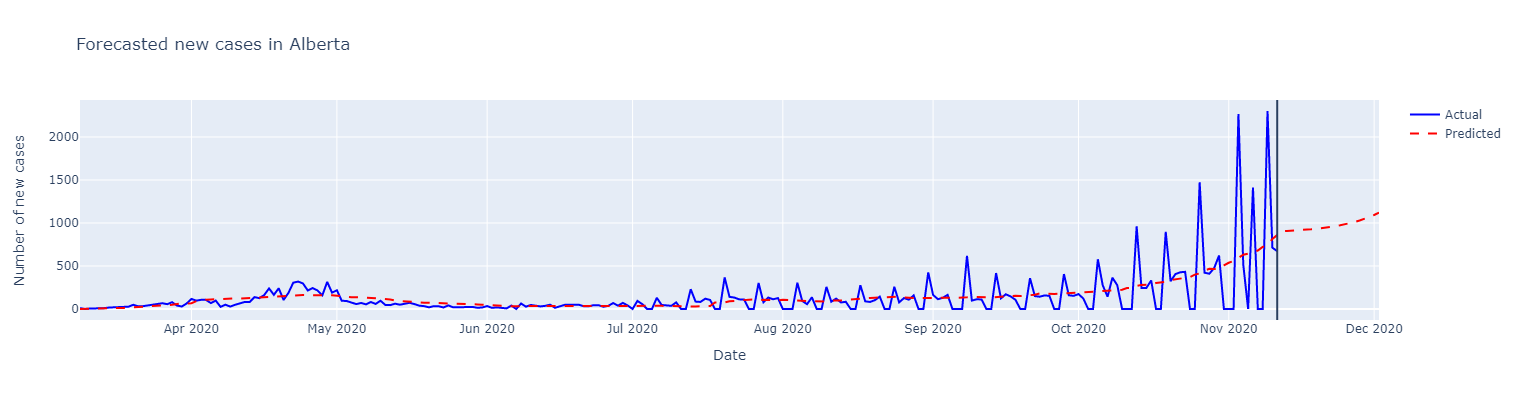

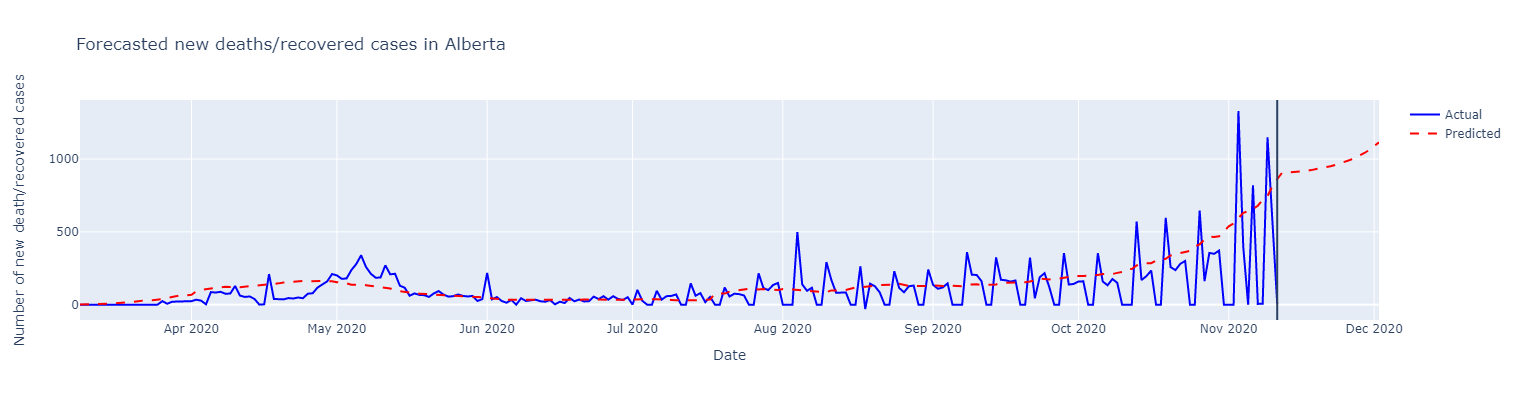

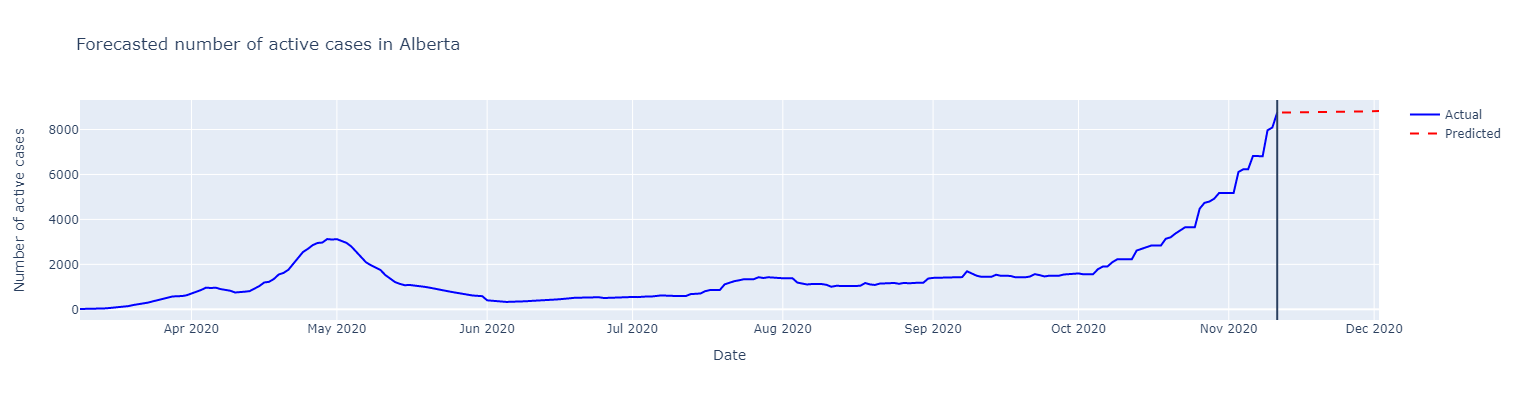

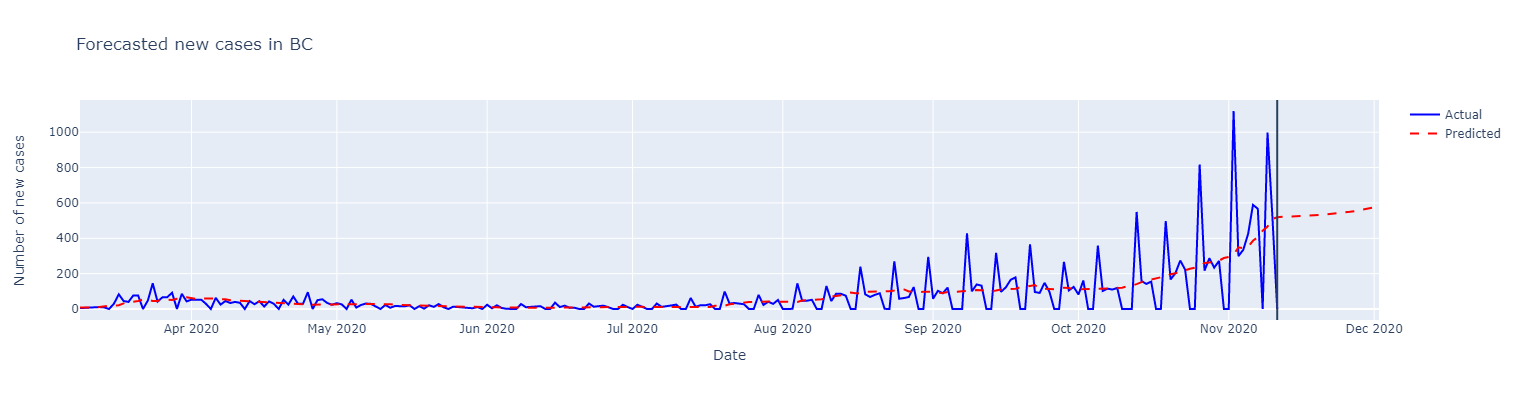

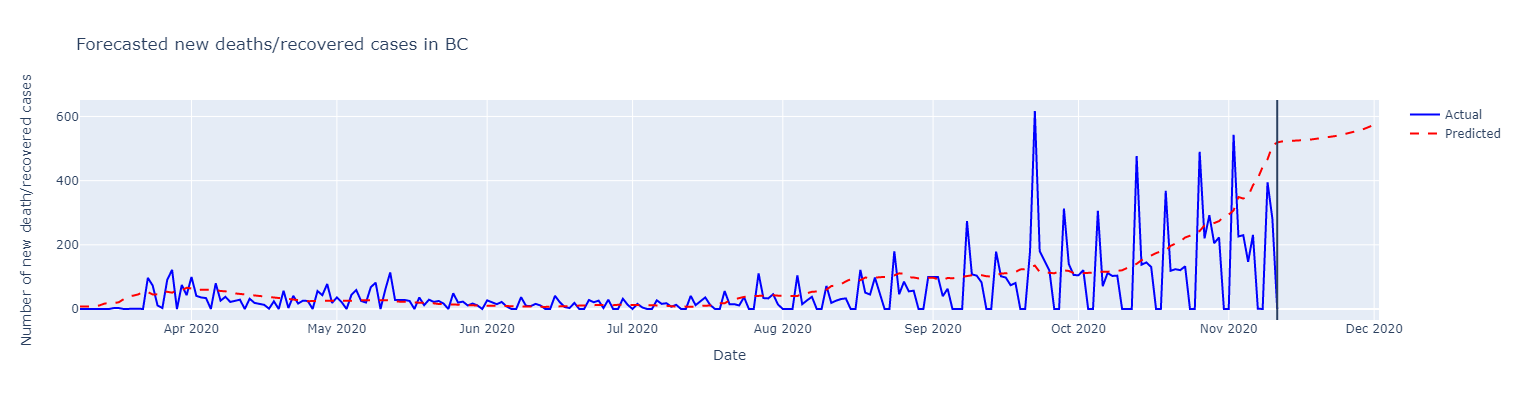

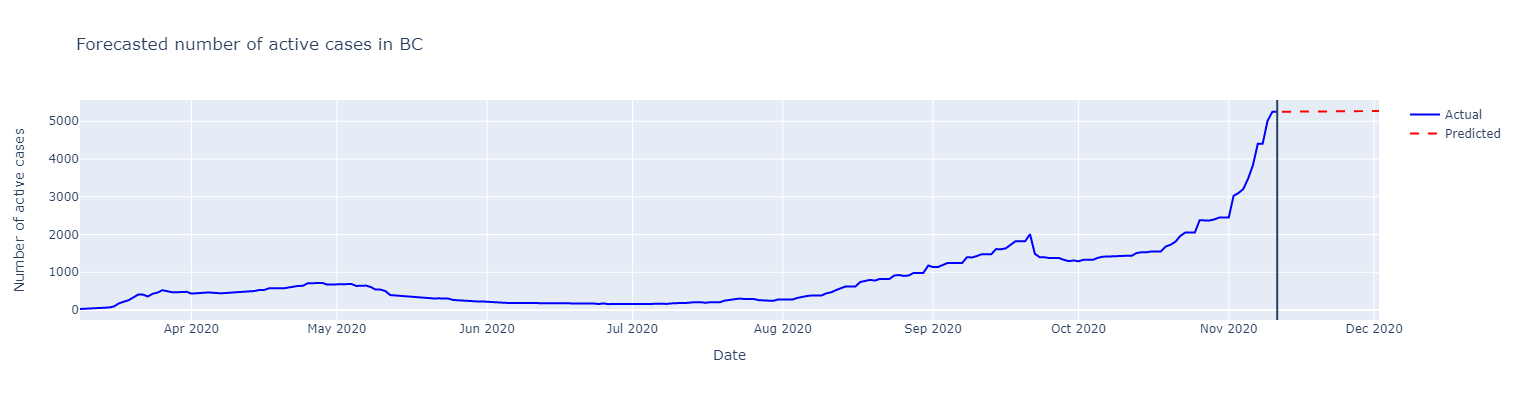

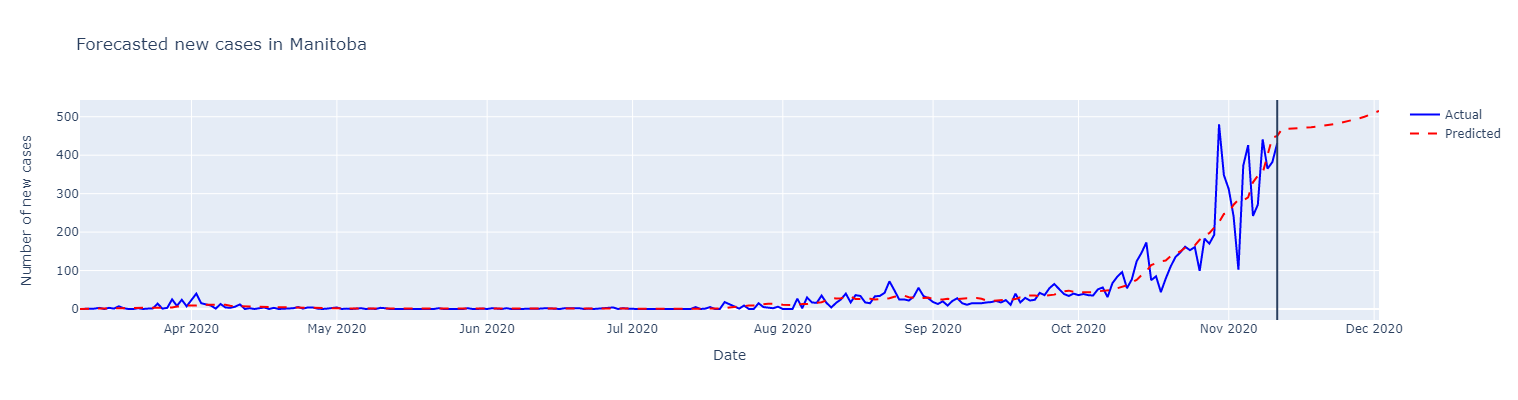

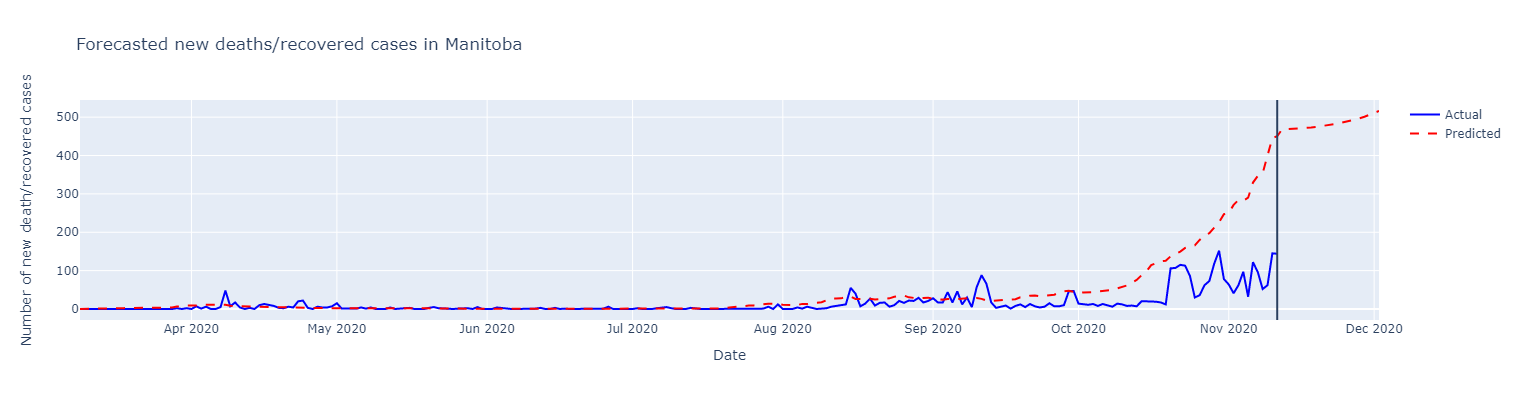

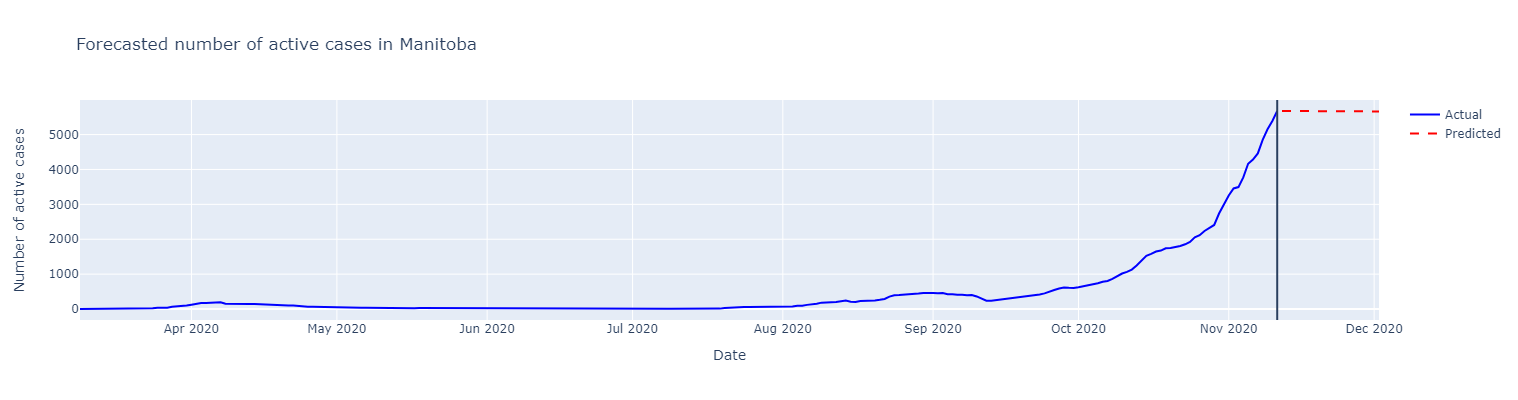

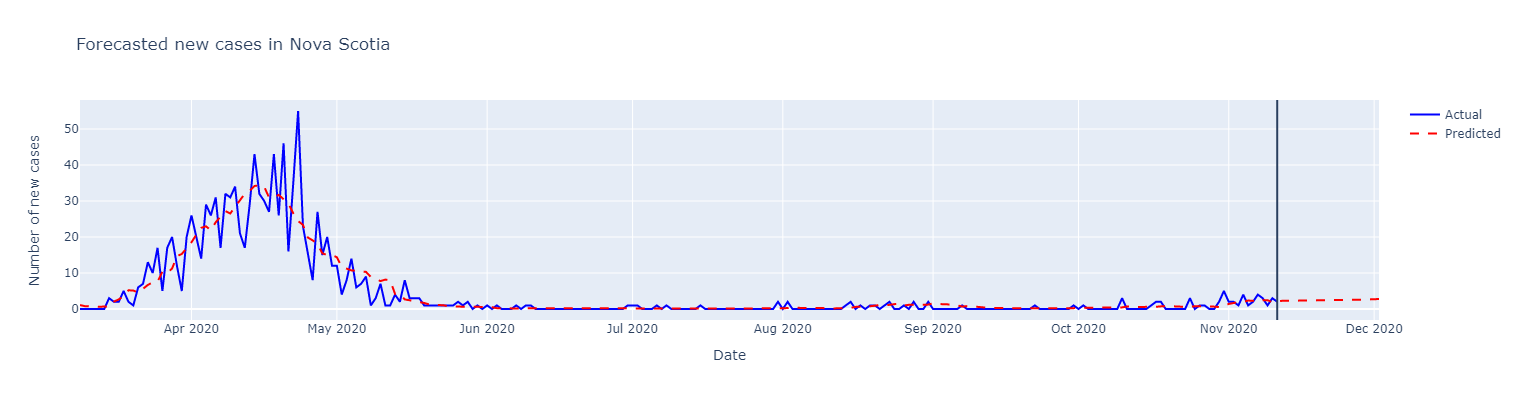

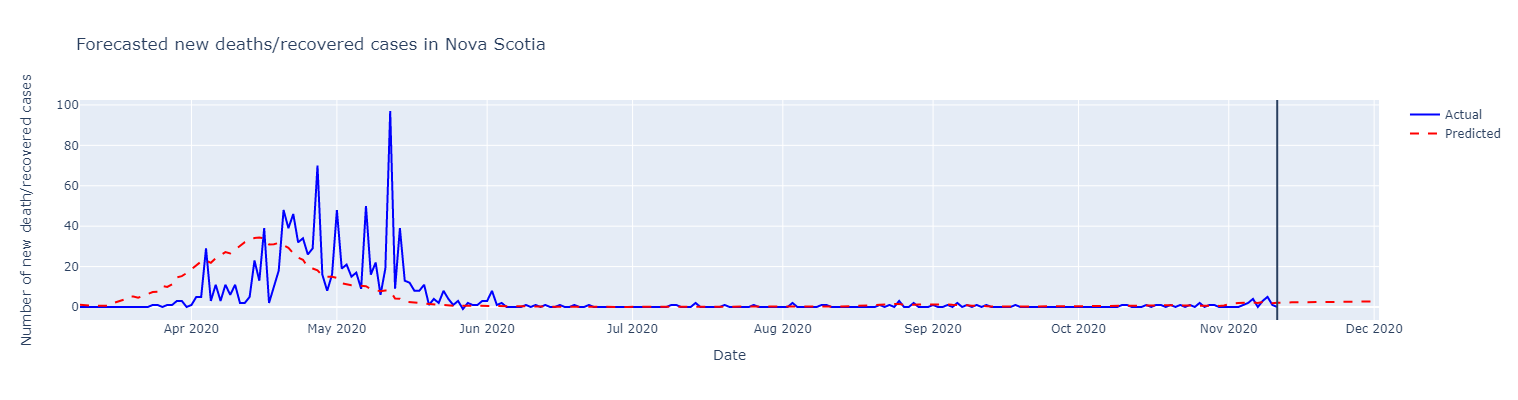

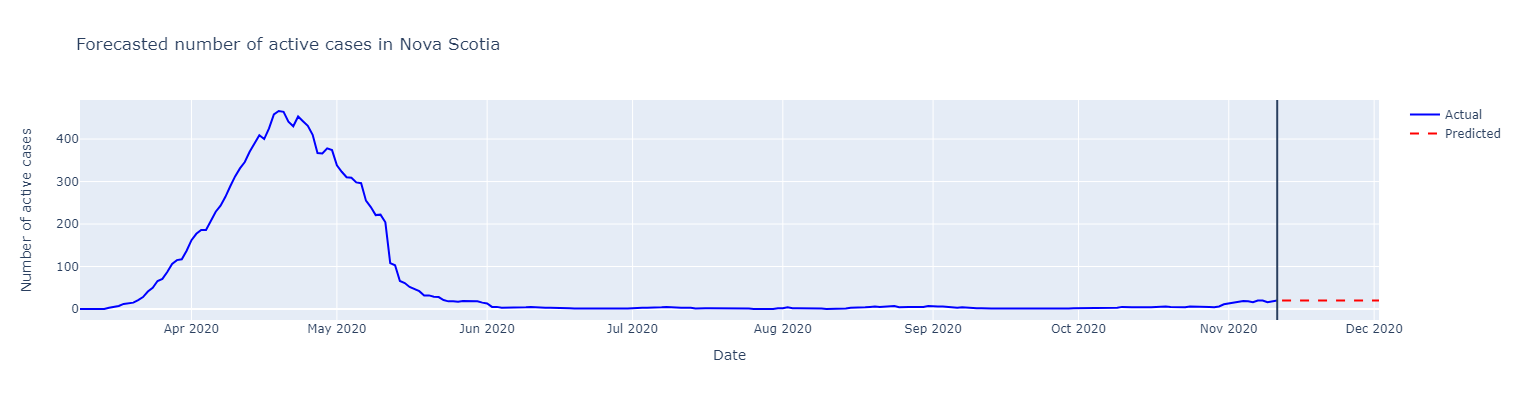

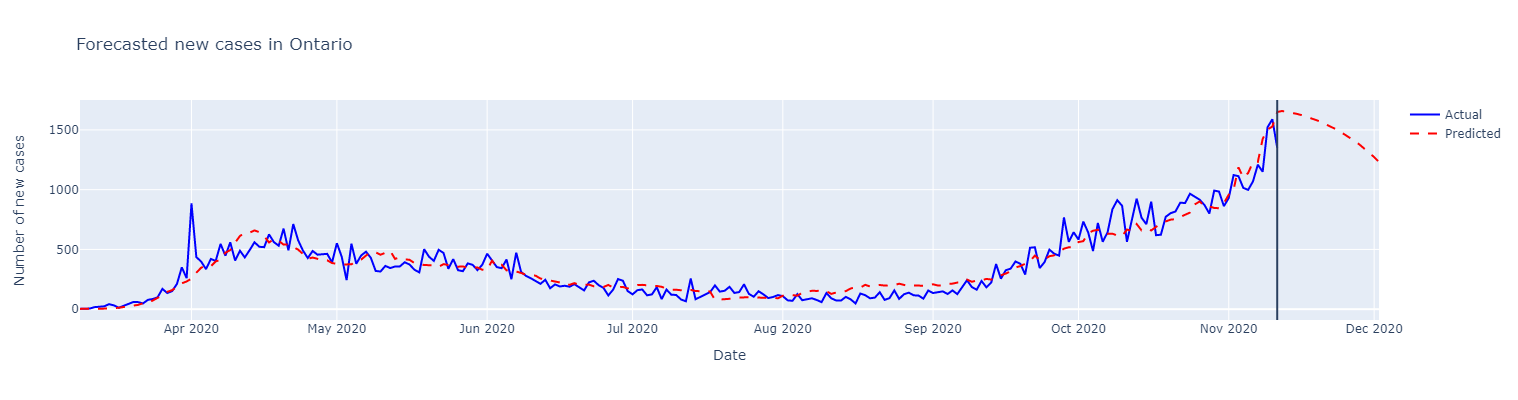

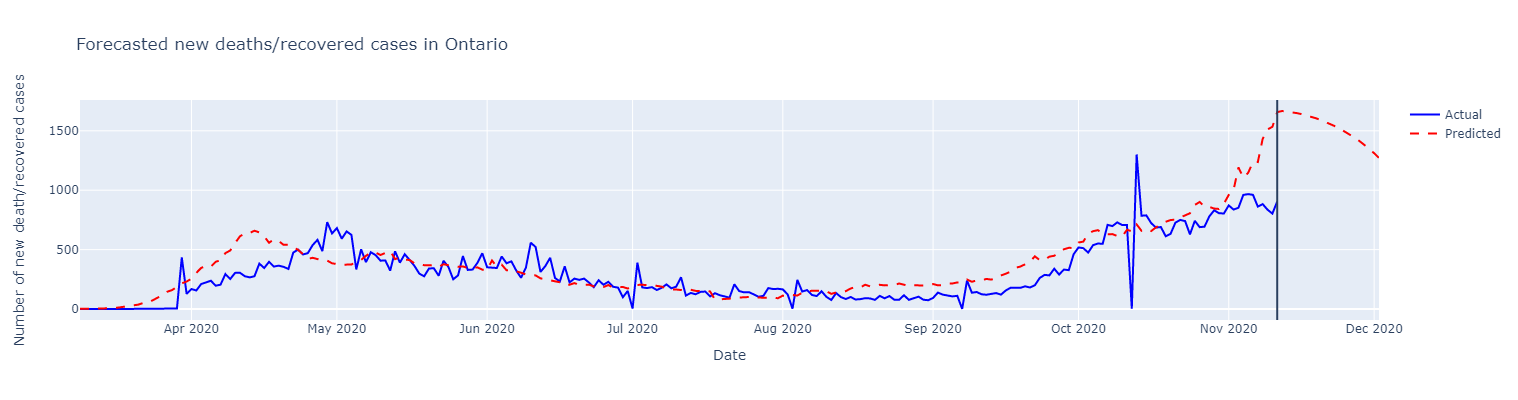

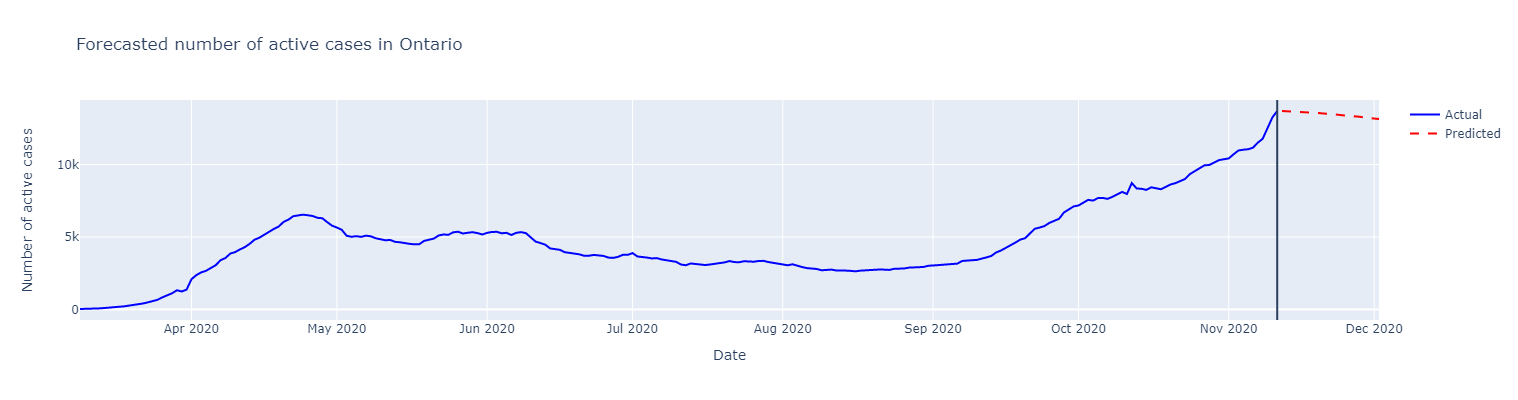

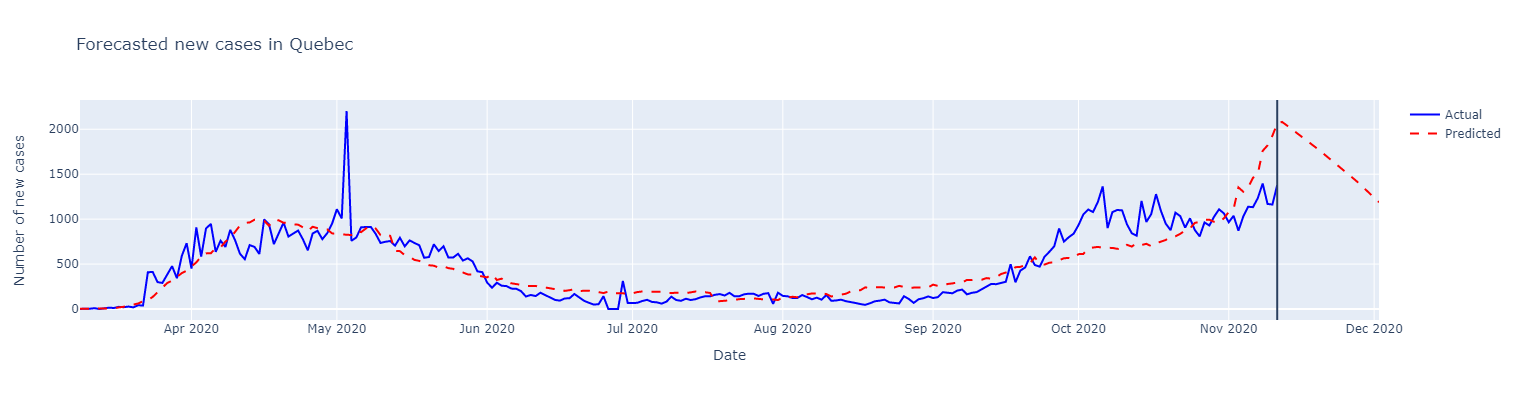

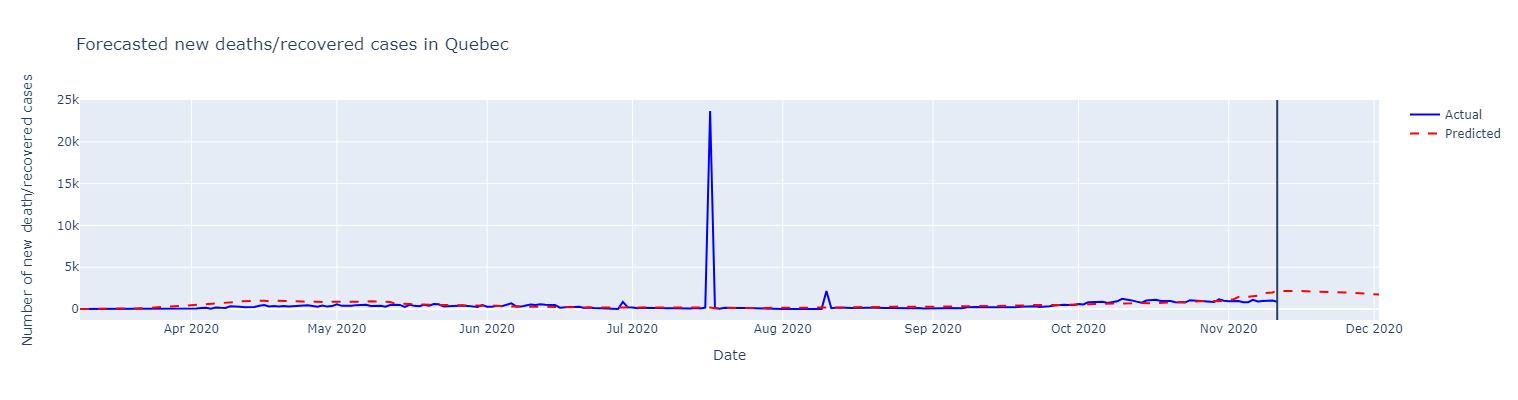

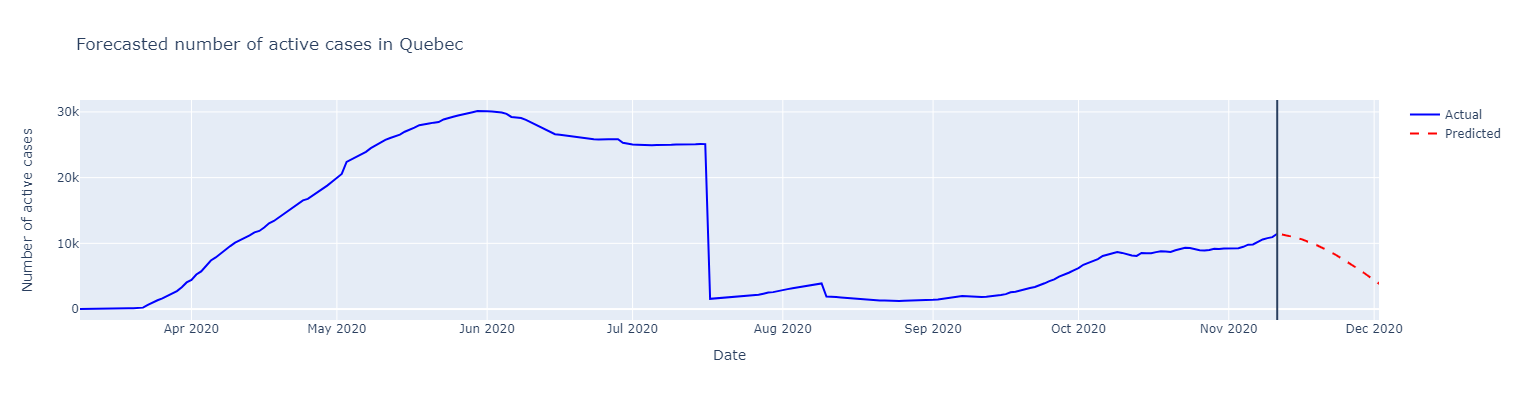

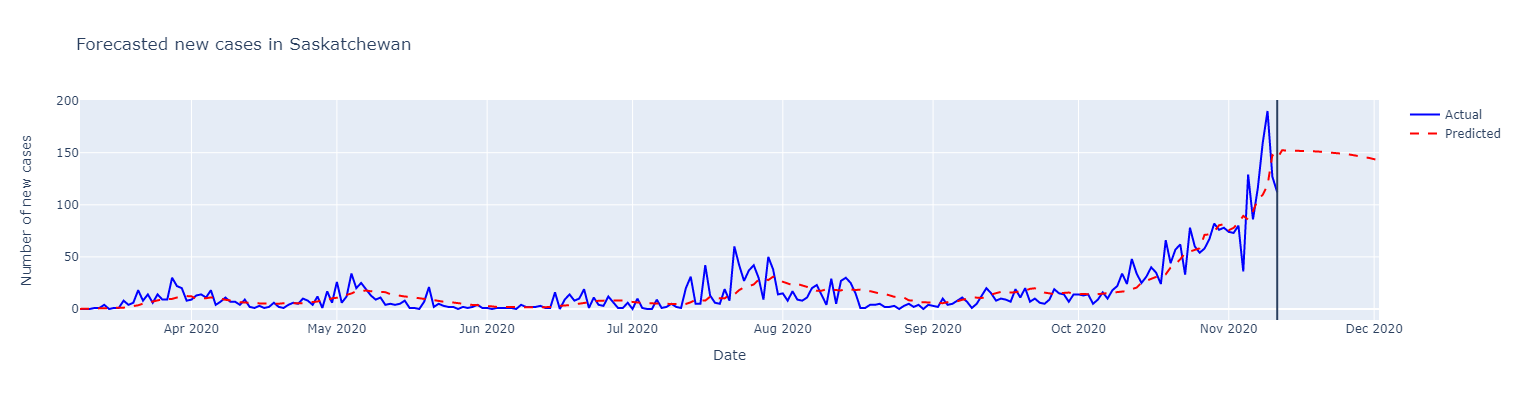

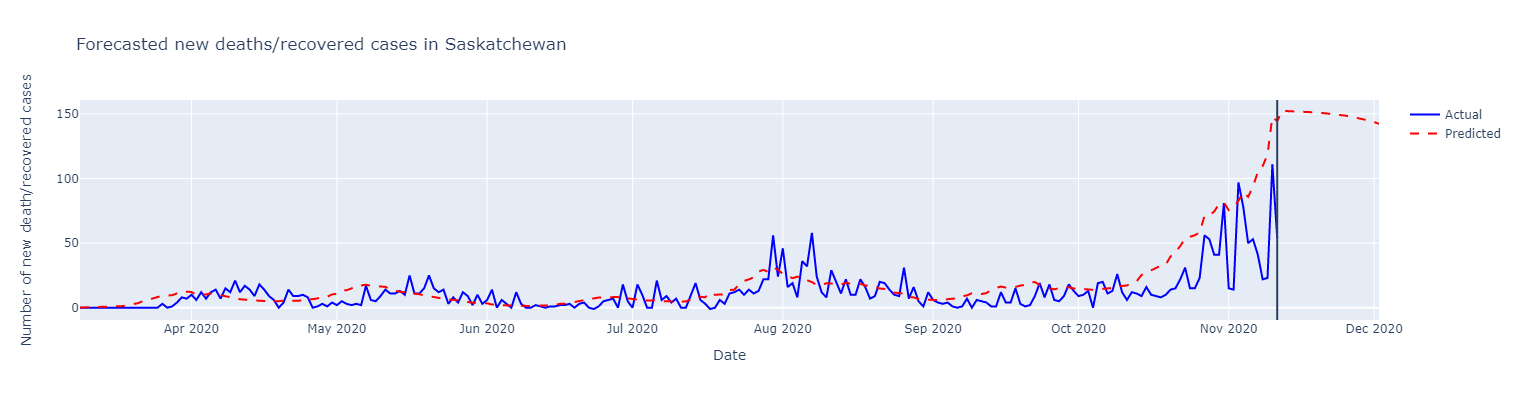

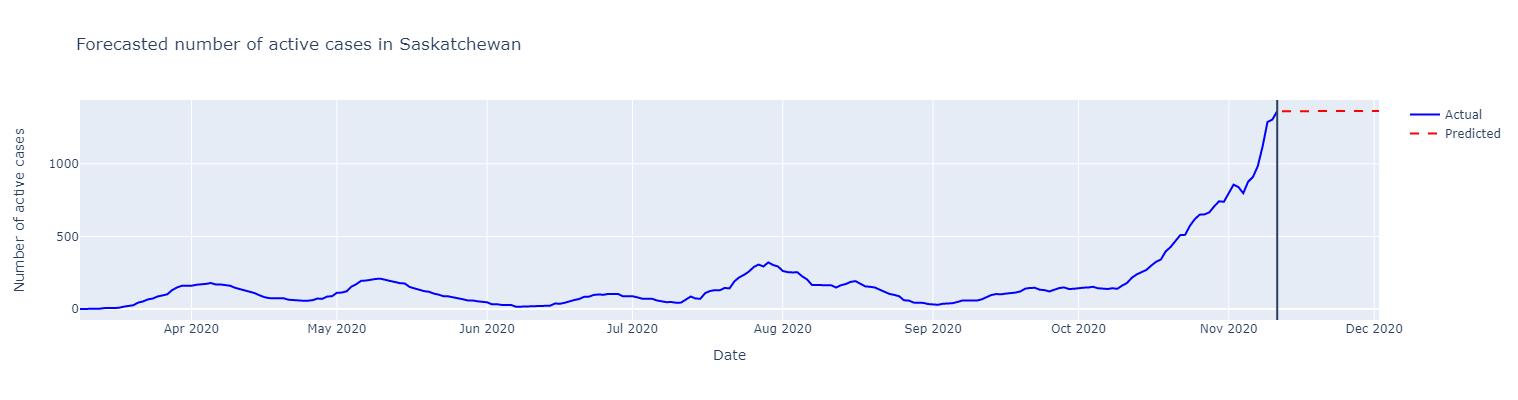

In [12]:
# Prediction plots for all provinces
provinces = active_cases_provinces['province'].unique()
for province in provinces:
    province_forecasts = forecasts.query(f'province == "{province}"')
    
    plot_predictions(province_forecasts,
                     y = 'cases',
                     y_label = 'Number of new cases',
                     title = f'Forecasted new cases in {province}',
                     include_ci = False)

    plot_predictions(province_forecasts,
                     y = 'removed',
                     y_label = 'Number of new death/recovered cases',
                     title = f'Forecasted new deaths/recovered cases in {province}',
                     include_ci = False)
    
    plot_predictions(province_forecasts,
                     y = 'active_cases',
                     y_label = 'Number of active cases',
                     title = f'Forecasted number of active cases in {province}')

### Cross validation